In [ ]:
'''
CODE BY NATE YEALANDS-FLINT
25051591@STUDENTS.LINCOLN.AC.UK
'''

In [1]:
# get spark up and running (do this once when you restart a colab session or it times out)

# first, install the jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# get spark itself
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz

# unzip spark
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# install findspark so colab notebook sees it
!pip install -q findspark

# and setup env variable so pyspark works
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# for using spark UI in colab... this allows tunnel to the UI
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Now spark is installed with correct env paths.. so use findspark to install it in colab
import findspark
findspark.init()

# start pyspark session
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# make the spark UI work in colab

get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels
spark

!pip install pandas


import seaborn as sb
import pandas as pd
from pyspark.sql.functions import col,asc,desc,mean,max,min,rand
from sklearn import tree,datasets,metrics,svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

--2023-01-19 00:15:08--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  64.7MB/s    in 0.2s    

2023-01-19 00:15:08 (64.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt

In [4]:
# read some data into a spark dataframe - do the same for pandas, as that's what we use for machine learning
reactorspark = spark.read.csv("/content/nuclear_plants_small_dataset.csv",header=True,inferSchema=True)
reactorpanda = pd.read_csv("/content/nuclear_plants_small_dataset.csv", delimiter=',', skipinitialspace=True, header=0)

In [ ]:
reactorspark.printSchema() #show schema for the dataframe

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Pressure _sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [ ]:
reactorspark.show() #print the dataframe

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [5]:
#saves time typing
#addresses spacing inconsistencies in names
#saves me time
prs1 = 'Power_range_sensor_1'
prs2 = 'Power_range_sensor_2'
prs3 = 'Power_range_sensor_3 '
prs4 = 'Power_range_sensor_4'
 
ps1 = 'Pressure _sensor_1'
ps2 = 'Pressure _sensor_2'
ps3 = 'Pressure _sensor_3'
ps4 = 'Pressure _sensor_4'

vs1 = 'Vibration_sensor_1'
vs2 = 'Vibration_sensor_2'
vs3 = 'Vibration_sensor_3'
vs4 = 'Vibration_sensor_4'

features = [prs1,prs2,prs3,prs4,ps1,ps2,ps3,ps4,vs1,vs2,vs3,vs4] #these are the features we will be using to train and test our machine learning algorithms

In [ ]:
nullCount = 0

nullCount += reactorspark.where(reactorspark[prs1].isNull()).count()
nullCount += reactorspark.where(reactorspark[prs2].isNull()).count()
nullCount += reactorspark.where(reactorspark[prs3].isNull()).count()
nullCount += reactorspark.where(reactorspark[prs4].isNull()).count()

nullCount += reactorspark.where(reactorspark[ps1].isNull()).count()
nullCount += reactorspark.where(reactorspark[ps2].isNull()).count()
nullCount += reactorspark.where(reactorspark[ps3].isNull()).count()
nullCount += reactorspark.where(reactorspark[ps4].isNull()).count()

nullCount += reactorspark.where(reactorspark[vs1].isNull()).count()
nullCount += reactorspark.where(reactorspark[vs2].isNull()).count()
nullCount += reactorspark.where(reactorspark[vs3].isNull()).count()
nullCount += reactorspark.where(reactorspark[vs4].isNull()).count()


nullCount #print missing cells

In [6]:
#filter by status
dfnorm = reactorspark.filter(reactorspark.Status == "Normal")
dfabn = reactorspark.filter(reactorspark.Status == "Abnormal") 

In [ ]:
#print summaries, showing only mean, minimum, median (referred to as 50%), maximum
#the cells are split by reactor status and sensor type
dfnorm.select(prs1,prs2,prs3,prs4).summary("Mean","Min","50%","Max").show()
dfnorm.select(ps1,ps2,ps3,ps4).summary("Mean","Min","50%","Max").show()
dfnorm.select(vs1,vs2,vs3,vs4).summary("Mean","Min","50%","Max").show()

+-------+--------------------+--------------------+---------------------+--------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|
+-------+--------------------+--------------------+---------------------+--------------------+
|   Mean|   5.602452811244976|   6.844503413654616|    9.292054016064245|   8.701398192771098|
|    Min|              0.0851|              0.0403|               4.3826|              0.1547|
|    50%|              5.1727|              6.6998|               9.2624|              9.2404|
|    Max|             12.1298|             11.9284|              14.0982|             16.3568|
+-------+--------------------+--------------------+---------------------+--------------------+

+-------+------------------+------------------+------------------+------------------+
|summary|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|
+-------+------------------+------------------+------------------+-

In [ ]:
dfabn.select(prs1,prs2,prs3,prs4).summary("Mean","Min","50%","Max").show()
dfabn.select(ps1,ps2,ps3,ps4).summary("Mean","Min","50%","Max").show()
dfabn.select(vs1,vs2,vs3,vs4).summary("Mean","Min","50%","Max").show()

+-------+--------------------+--------------------+---------------------+--------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|
+-------+--------------------+--------------------+---------------------+--------------------+
|   Mean|   4.396694975903612|   5.914042891566265|    9.164170212851408|    6.00914597991968|
|    Min|              0.0082|              0.3891|             2.583966|              0.0623|
|    50%|              4.5053|            5.929872|               9.4666|              5.3952|
|    Max|           10.923078|             10.1541|              15.7599|           17.235858|
+-------+--------------------+--------------------+---------------------+--------------------+

+-------+------------------+------------------+------------------+------------------+
|summary|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|
+-------+------------------+------------------+------------------+-

In [7]:
#convert to pandas for box plotting
pandanorm = dfnorm.toPandas()
pandaAbn = dfabn.toPandas()

## Create box plots
Done by status and sensor type

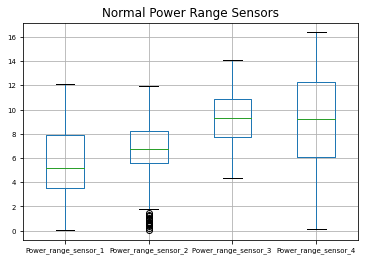

In [ ]:
pandanorm.boxplot(column=[prs1,prs2,prs3,prs4], fontsize = 7)
plt.title("Normal Power Range Sensors") #add title
plt.show()

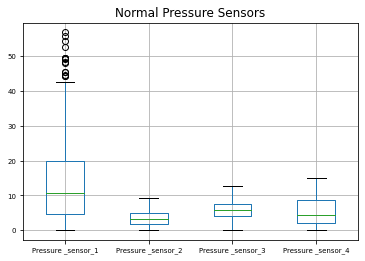

In [ ]:
pandanorm.boxplot(column=[ps1,ps2,ps3,ps4],fontsize = 7)
plt.title("Normal Pressure Sensors")
plt.show()

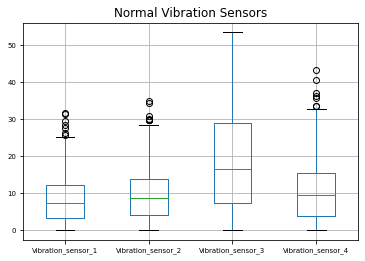

In [ ]:
pandanorm.boxplot(column=[vs1,vs2,vs3,vs4],fontsize = 7)
plt.title("Normal Vibration Sensors")
plt.show()

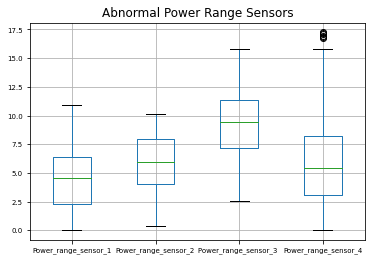

In [ ]:
pandaAbn.boxplot(column=[prs1,prs2,prs3,prs4],fontsize = 7)
plt.title("Abnormal Power Range Sensors")
plt.show()

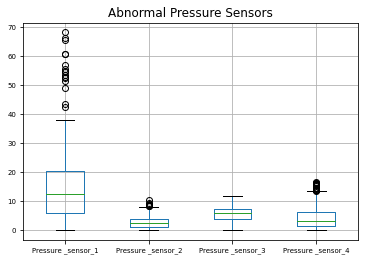

In [8]:
pandaAbn.boxplot(column=[ps1,ps2,ps3,ps4],fontsize = 7)
plt.title("Abnormal Pressure Sensors")
plt.show()

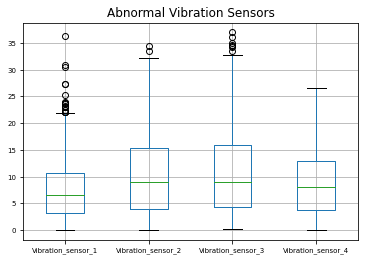

In [ ]:
pandaAbn.boxplot(column=[vs1,vs2,vs3,vs4],fontsize = 7)
plt.title("Abnormal Vibration Sensors")
plt.show()

In [ ]:
datacorr = reactorpanda.corr() #get correlation matrix
datacorr

,Power_range_sensor_1,Power_range_sensor_2,Power_range_sensor_3,Power_range_sensor_4,Pressure _sensor_1,Pressure _sensor_2,Pressure _sensor_3,Pressure _sensor_4,Vibration_sensor_1,Vibration_sensor_2,Vibration_sensor_3,Vibration_sensor_4
Power_range_sensor_1,1.000000,0.095235,0.229943,0.499795,0.047805,0.652081,0.199811,0.406382,-0.152247,-0.003684,0.106583,0.014177
Power_range_sensor_2,0.095235,1.000000,0.693818,0.228438,-0.222160,0.112438,0.583086,0.136380,-0.119142,0.011013,0.243242,0.058244
Power_range_sensor_3,0.229943,0.693818,1.000000,0.083362,-0.255865,0.166549,0.362688,0.062479,-0.249057,-0.038320,0.215811,-0.023962
Power_range_sensor_4,0.499795,0.228438,0.083362,1.000000,0.150635,0.567705,-0.070547,0.823637,-0.114117,0.043383,0.330499,-0.018193
Pressure _sensor_1,0.047805,-0.222160,-0.255865,0.150635,1.000000,0.116859,-0.118713,0.131136,0.101438,-0.035196,-0.084575,-0.125128
Pressure _sensor_2,0.652081,0.112438,0.166549,0.567705,0.116859,1.000000,0.091341,0.571403,-0.099950,-0.027698,0.011015,0.001189
Pressure _sensor_3,0.199811,0.583086,0.362688,-0.070547,-0.118713,0.091341,1.000000,0.001591,0.016497,0.029766,0.019993,0.105642
Pressure _sensor_4,0.406382,0.136380,0.062479,0.823637,0.131136,0.571403,0.001591,1.000000,-0.112696,0.010560,0.191842,0.047000
Vibration_sensor_1,-0.152247,-0.119142,-0.249057,-0.114117,0.101438,-0.099950,0.016497,-0.112696,1.000000,-0.045857,-0.076277,0.026480
Vibration_sensor_2,-0.003684,0.011013,-0.038320,0.043383,-0.035196,-0.027698,0.029766,0.010560,-0.045857,1.000000,0.103704,-0.023290


## Machine Learning Preparation

In [ ]:
statmap = {"Normal": 0, "Abnormal": 1}
reactorpanda["Status"] = reactorpanda["Status"].map(statmap) # maps status words to the number for the machine learning algorithms

In [ ]:
pandatrain,pandatest = train_test_split(reactorpanda,test_size=0.3)
#count number of items in the split dataset
print(pandatrain['Status'].count())
print(pandatest['Status'].count())

697
299


In [ ]:
print(len(pandatrain[pandatrain['Status'] == 0]))
print(len(pandatrain[pandatrain['Status'] == 1]))
#count how many of each status type there is

342
355


In [ ]:
print(len(pandatest[pandatest['Status'] == 0]))
print(len(pandatest[pandatest['Status'] == 1]))

156
143


In [ ]:
trainX = pandatrain[features] #split the train data into X, with features
trainY = pandatrain['Status'] #and Y, with the status'

In [ ]:
#creates dataframe for results to go into
def resultGet(err,sen,spec):
  table = {"Metrics": ["Error Rate", "Sensitivity", "Specificity"], "Result": [err,sen,spec]}
  df = pd.DataFrame(data=table)
  return df

###Decision Tree

In [ ]:
dtree = DecisionTreeClassifier() # create a decision tree
dtree = dtree.fit(trainX,trainY)
testPreddt = dtree.predict(pandatest[features]) #test predictions go in an array

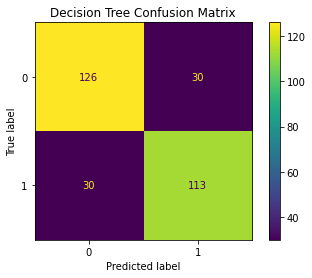

In [ ]:
conmat = metrics.confusion_matrix(pandatest["Status"], testPreddt) #make a confusion matrix


dtcm = metrics.ConfusionMatrixDisplay(confusion_matrix = conmat, display_labels = [0, 1])

dtcm.plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [ ]:
err = 1 - metrics.accuracy_score(pandatest["Status"], testPreddt) #1-accuracy gets error rate
sens = metrics.recall_score(pandatest["Status"], testPreddt) #sensiivity
spec = metrics.recall_score(pandatest["Status"], testPreddt, pos_label=0) #specifity - as it's opposite of sensitivity, take opposite position label

print(resultGet(err,sens,spec))

       Metrics    Result
0   Error Rate  0.200669
1  Sensitivity  0.790210
2  Specificity  0.807692


###Suport Vector Model

In [ ]:
clf = svm.SVC() #create a support vector machine and do exactly same process as with decision tree
clf.fit(trainX,trainY)
testPredsvm = clf.predict(pandatest[features])

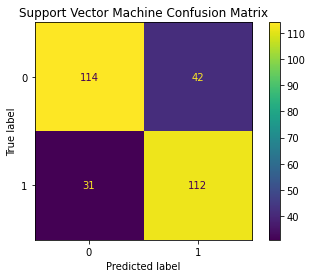

In [ ]:
conmat = metrics.confusion_matrix(pandatest["Status"], testPredsvm)
svmcm = metrics.ConfusionMatrixDisplay(confusion_matrix = conmat, display_labels = [0, 1])
svmcm.plot()

plt.title("Support Vector Machine Confusion Matrix")
plt.show()

In [ ]:
err = 1 - metrics.accuracy_score(pandatest["Status"], testPredsvm)
sens = metrics.recall_score(pandatest["Status"], testPredsvm)
spec = metrics.recall_score(pandatest["Status"], testPredsvm, pos_label=0)

print(resultGet(err,sens,spec))

       Metrics    Result
0   Error Rate  0.244147
1  Sensitivity  0.783217
2  Specificity  0.730769


In [ ]:
supportvecs = clf.support_vectors_ #print the support vectors
supportvecs

array([[ 2.6413  , 10.7758  , 14.0982  , ..., 17.1338  , 31.6827  ,
         6.0651  ],
       [ 5.9253  ,  0.2161  ,  6.2439  , ..., 14.4843  , 25.4514  ,
         5.9267  ],
       [ 4.4449  ,  5.1434  ,  6.7538  , ...,  8.8531  ,  5.4466  ,
        22.7835  ],
       ...,
       [ 4.706586,  5.369586, 10.162056, ...,  0.734502,  3.691176,
        11.431242],
       [ 5.137   ,  5.3503  ,  9.2157  , ..., 18.9524  , 14.4566  ,
         9.8316  ],
       [ 3.254412,  6.055026,  9.47937 , ..., 15.85692 ,  0.169524,
         1.42188 ]])

### Artificial Neural Network

In [ ]:
ann = MLPClassifier(solver='lbfgs', alpha=1e-53, hidden_layer_sizes=(2, 2), random_state=0)
#make an artificial neural network. set hidden layer sizes to be of two hidden layers with two nodes
ann.fit(trainX,trainY)
testPredann = ann.predict(pandatest[features])

NameError: ignored

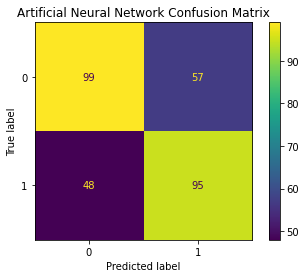

In [ ]:
conmat = metrics.confusion_matrix(pandatest["Status"], testPredann) #repeat confusion matrix, error rate etc calculation process
anncm = metrics.ConfusionMatrixDisplay(confusion_matrix = conmat, display_labels = [0, 1])
anncm.plot()
plt.title("Artificial Neural Network Confusion Matrix")
plt.show()

In [ ]:
err = 1 - metrics.accuracy_score(pandatest["Status"], testPredann)
sens = metrics.recall_score(pandatest["Status"], testPredann)
spec = metrics.recall_score(pandatest["Status"], testPredann, pos_label=0)

print(resultGet(err,sens,spec))

       Metrics    Result
0   Error Rate  0.351171
1  Sensitivity  0.664336
2  Specificity  0.634615
